In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture



In [14]:
linkedin_dataset = pd.read_csv('linkedin_dataset.csv')

In [15]:
cols = ['skills_desc', 'type', 'pay_period', 'currency', 'compensation_type', 'posting_domain',
                           'application_url', 'formatted_experience_level', 'company_size', 'zip_code', 'address',
                           'state', 'url', 'city', 'country', 'name']
for col in cols:
    linkedin_dataset[col].fillna("Not Specified", inplace=True)

cols_fill_zero = ['applies', 'views', 'follower_count', 'employee_count']
for col in cols_fill_zero:
    linkedin_dataset[col].fillna(0, inplace=True)

linkedin_dataset['remote_allowed'].fillna("Unknown", inplace=True)
linkedin_dataset['description_x'].fillna("Not Specified", inplace=True)
linkedin_dataset_cleaned = linkedin_dataset.drop_duplicates()

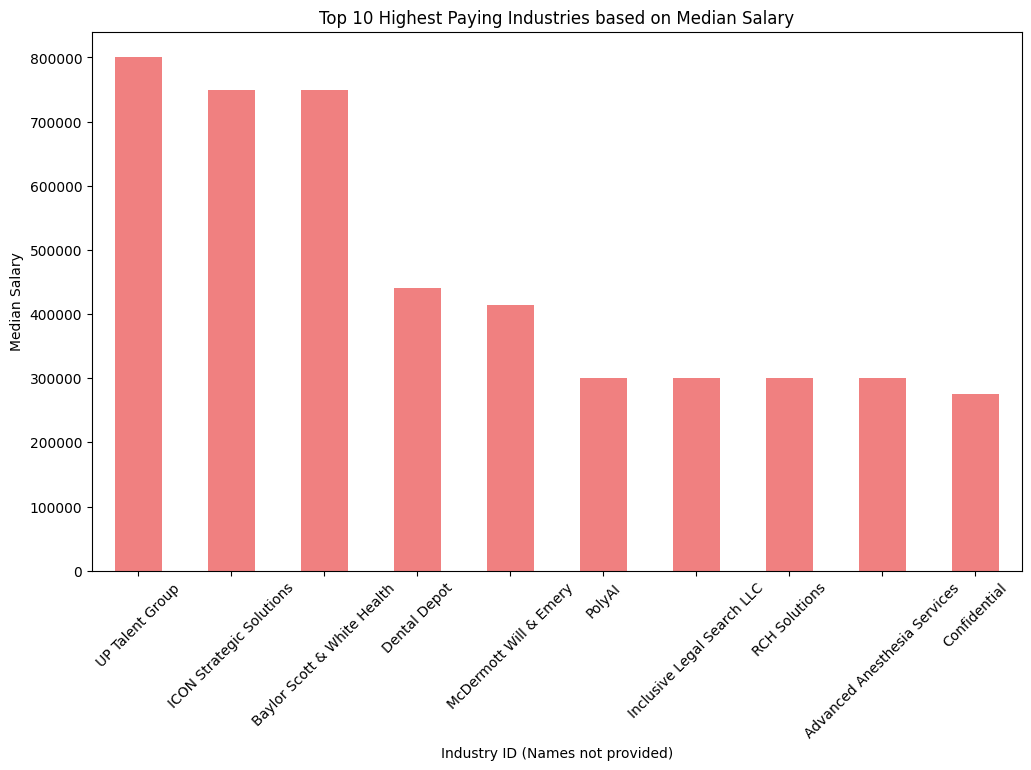

In [16]:
industry_salaries = linkedin_dataset_cleaned.groupby('name')['med_salary'].median().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
industry_salaries.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Highest Paying Industries based on Median Salary')
plt.xlabel('Industry ID (Names not provided)')
plt.ylabel('Median Salary')
plt.xticks(rotation=45)
plt.show()

/home/anupriya/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/anupriya/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/anupriya/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/anupriya/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

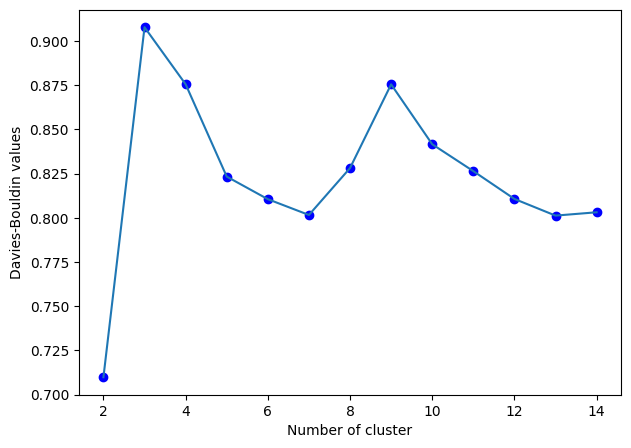

In [17]:
linkedin_dataset_cleaned['combined_text'] = linkedin_dataset_cleaned['description_x']+ ' ' + linkedin_dataset_cleaned['skills_desc'] + ' ' + linkedin_dataset_cleaned['skills_desc']

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(linkedin_dataset_cleaned['combined_text'])

svd_2d = TruncatedSVD(n_components=2, random_state=42)
reduced_data = svd_2d.fit_transform(tfidf_matrix)

# KMeans clustering
#Finding Optimal Number of Clusters using DB-Index method
from sklearn.metrics import davies_bouldin_score
sse,db = {}, {}
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=10)
    labels=kmeans.fit_predict(reduced_data)
    sse[k] = kmeans.inertia_ 
    db[k] = davies_bouldin_score(reduced_data,labels)

plt.figure(figsize=(7,5))
plt.plot(list(db.keys()), list(db.values()), 'bo')
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

/home/anupriya/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


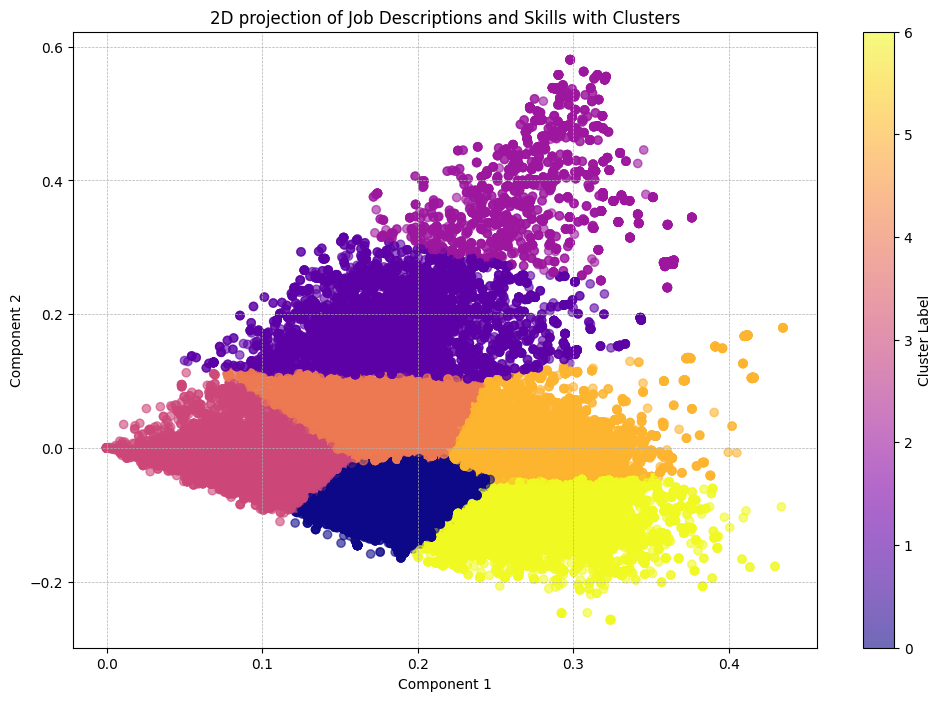

In [18]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)
linkedin_dataset_cleaned['cluster_kmeans'] = kmeans_labels

plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='plasma', alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D projection of Job Descriptions and Skills with Clusters')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Optimal number of clusters are:  14


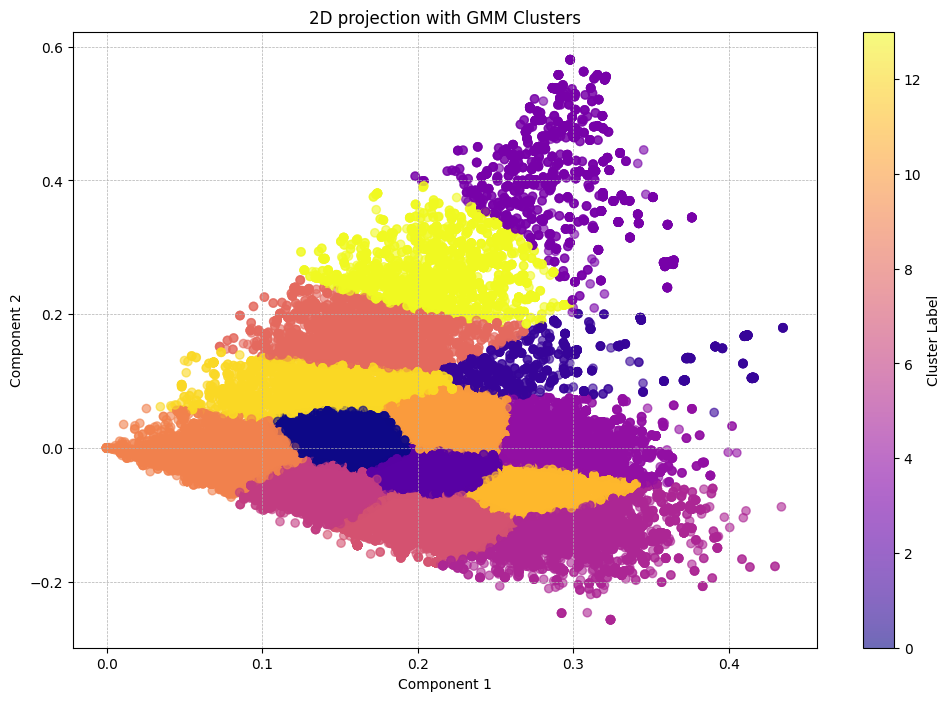

In [19]:
# GMM clustering
n_components_range = range(2, 15)

bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(reduced_data)
    bic_scores.append(gmm.bic(reduced_data))

# Find the optimal number of clusters with the lowest BIC
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print("Optimal number of clusters are: ",optimal_n_components)

optimal_gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_labels = optimal_gmm.fit_predict(reduced_data)

linkedin_dataset_cleaned['cluster_gmm'] = gmm_labels

plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='plasma', alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D projection with GMM Clusters')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [20]:
db_index_kmeans = davies_bouldin_score(reduced_data, kmeans_labels)
db_index_gmm = davies_bouldin_score(reduced_data, gmm_labels)

print("Davies-Bouldin Index (K-means):", db_index_kmeans)
print("Davies-Bouldin Index (GMM):", db_index_gmm)


Davies-Bouldin Index (K-means): 0.8032284010900168
Davies-Bouldin Index (GMM): 0.8335848259921436
